In [2]:
# Definitions and functions
%matplotlib inline
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import wave
import struct
import h5py
from scipy.io import wavfile
from scipy.signal import spectrogram
import logging
from IPython.display import display
matplotlib.style.use('ggplot')
from ipywidgets import *
import yaml
import numpy.lib.recfunctions as rfn 
import numpy.matlib as npm
import glob

# Check wich computer to decide where the things are mounted
comp_name=socket.gethostname()
print 'Computer: ' + comp_name

if 'txori' in comp_name or 'passaro' in comp_name or 'lintu' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

sys.path.append(os.path.join(repos_folder, 'ephysflow'))
sys.path.append(os.path.join(repos_folder, 'swissknife'))

# Careful with these: basic_viewing should be replaced soon
from basic_viewing import events as evt
# from basic_viewing.structure import kwik_functions as kwkf
# from basic_viewing.structure.core import h5_functions as kwdf

from swissknife.bci.core import kwik_functions as kwkf
from swissknife.bci.core.file import h5_functions as kwdf 
from swissknife.bci.core import expstruct as et
from swissknife.bci import events
from swissknife.h5tools import h5tools as h5
from swissknife.streamtools import streams as st
from swissknife.streamtools import spectral as sp
from swissknife.streamtools import temporal as tp


logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)



logger.debug('All modules loaded')

Computer: passaro


In [3]:
def list_sum(a_list):
    s = a_list[0]
    for new_s in a_list[1:]:
        s+=new_s
    return s


def collect_frames(starts, span, s_f, kwd_file, recs_list, chan_list):
    frames = []
    bad_frames = []
    logger.info('Collecting {} frames...'.format(starts.size))
    for i_start, start in enumerate(starts):
        if i_start % 10 == 0:
            logger.info("Frame {} ...".format(i_start))
        rec = recs_list[i_start]
        try:
            one_frame = st.Chunk(st.H5Data(kwdf.get_data_set(kwd_file, rec),
                                           s_f,
                                           dtype=np.float),
                                 np.array(chan_list),
                                 [start, start + span])
            frames.append(one_frame)
        except AssertionError:
            logger.warning('Frame out of bounds [{0}:{1}]'.format(start, start+span))
            bad_frames.append(i_start)
    return frames, np.delete(starts, bad_frames), np.delete(recs_list, bad_frames)

def identity(x):
    return x

def collect_frames_stream(starts, span, s_f, kwd_file, recs_list, chan_list):
    recs = np.unique(recs_list)
    logger.info('Collecting {} recs...'.format(recs.size))
    all_frames = []
    for i_rec, rec in enumerate(recs):
        logger.info("Rec {} ...".format(rec))
        stream_obj = st.H5Data(kwdf.get_data_set(kwd_file, rec), s_f, dtype=np.float)
        starts_from_rec = stars[recs_list==rec]
        rec_frames = stream_obj.apply_repeated(starts, window, lambda x: x)
        all_frames.append[rec_frames]
    return all_frames

def gather_all_frames(bird_id, sess_id, viz_set, stim_name='bos_tag'):
    exp_pars = et.get_parameters(bird_id, sess_id)
    f_n = et.file_names(bird, sess)


    
    
    stim_id = et.stim_id(exp_pars, stim_name)
    stim_file_path = et.file_path(f_n, 'ss', 'sng')
    with h5py.File(stim_file_path, 'r') as stim_file:
        stim = evt.Song(stim_id, stim_file)    
        starts = stim.get_start()
        recs = stim.get_rec()

    stimm_path = os.path.join(f_n['folders']['stim'], viz_set['stim_sess'], 
                      exp_par['search_motiff']['motiff_patterns'][stim_name])
    stim_chunk = st.Chunk(st.WavData2(m_path))
    
    before = viz_set['before_samp']
    after = viz_set['after_samp']
    with et.open_kwd(bird_id, sess_id) as kwd_f:
        v_frames, v_starts, v_recs = collect_frames(starts-before, before+after+stim_chunk.samples, 
                            s_f, 
                            kwd_f, recs, viz_set['channels'])
    
    return v_frames, v_starts, v_recs, stim_chunk

def band_pass_filter(chunk, hp_b, hp_a, lp_b, lp_a):    
    chunk_hi = sg.filtfilt(hp_b, hp_a, chunk)
    chunk_filt = sg.filtfilt(lp_b, lp_a, chunk_hi)
    return chunk_filt

In [5]:
# This should somehow be part of expstruct, maybe
# get the raw parameters and get the config file in the raw file
from swissknife.h5tools import h5tools as h5t
reload(h5t)

def get_all_rec_attribs(bird, sess, location='ss'):
    rec_list = et.get_rec_list(bird, sess, location=location)
    r_attrs = {}
    with et.open_kwd(bird, sess, location=location) as f:
        r_attrs = h5t.group_2_dict({}, f['/recordings'], 'aux')['aux']
    return r_attrs

def get_rec_attribs(bird, sess, rec='0', location='ss'):
    return get_all_rec_attribs(bird, sess, location=location)['{}'.format(rec)]

def get_rec_origin(bird, sess, rec='0', location='ss'):
    rec_attr = get_rec_attribs(bird, sess, rec=rec, location=location)['name'].split(':')
    rec_orig = {} 
    [sess_path, rec_orig['file']] = os.path.split(rec_attr[0])
    rec_orig['sess'] = os.path.split(sess_path)[-1]
    rec_orig['rec'] = rec_attr[1].split('/recordings/')[-1]
    return rec_orig

def get_raw_par(bird, sess, rec='0', location='ss', raw_location='rw'):
    rec_origin = get_rec_origin(bird, sess, rec=rec, location=location)
    return et.get_parameters(bird, rec_origin['sess'], rec=rec, location=raw_location)

def load_site_chan_map(bird, sess, rec='0', location='ss', raw_location='rw'):
    
    rw_par = get_raw_par(bird, sess, rec=rec, location=location, raw_location=raw_location)
    ss_par = et.get_parameters(bird, sess, location=location)
    
    rw_chans = np.array(rw_par['channel_config']['neural'])
    ss_chans = np.array(ss_par['channel_config']['neural'])
    
    probe = et.load_probe(bird, sess, location=location)
    raw_geom = probe['channel_groups'][0]['geometry']
    
    return {ss_ch: raw_geom[rw_chans[ss_ch]] for ss_ch in ss_chans}

def chan_positions(chans, site_map):
    return np.vstack([np.array(site_map[ch]) for ch in chans])


In [6]:
song_spectr_pars = {'n_window': 512,
                 'n_overlap': 511,
                 'sigma': 30,
                 'f_cut': 10000,
                 'db_cut': 0.000065 }

lfp_spectro_pars={'n_window': 512,
                 'n_overlap': 511,
                 'sigma': 30,
                 'f_cut': 150,
                 'db_cut': 0.000065 }

lfp_filter_band = [1, 1250]




In [7]:
# bird and session

bird = 'z034'
sess = 'day-anesth_surface_depth_2017-03-10_16-30-53_450'
stim_sess = '001'

    
exp_par = et.get_parameters(bird, sess)
fn = et.file_names(bird, sess)
song_file_path = et.file_path(fn, 'ss', 'sng')
song_file = h5py.File(song_file_path, 'r')

pattern_names = et.get_stims_dict(bird, sess)

print pattern_names

{'bos01-rev_tag': 'bos01-rev_tag.wav', 'bos01_tag': 'bos01_tag.wav'}


In [8]:
#rat = get_all_rec_attribs(bird, sess)
recat = get_rec_attribs(bird, sess)
rec_or = get_rec_origin(bird, sess)
rp = get_raw_par(bird, sess)

In [9]:
def get_evet(stim_name, bird, sess):
    ex_par = et.get_parameters(bird, sess)
    st_id = et.stim_id(ex_par, stim_name)
    ev_file_path = et.file_path(et.file_names(bird, sess), 'ss', 'sng')
    ev_file = h5py.File(ev_file_path, 'r')
    return evt.Song(st_id, ev_file)

In [ ]:
reload(sp)
#pattern
m_name = 'bos01_tag'
m_path = os.path.join(et.file_names(bird)['folders']['stim'], stim_sess, 
                      exp_par['search_motiff']['motiff_patterns'][m_name])

m_id = et.stim_id(exp_par, m_name)

m = evt.Song(m_id, song_file)
m_chunk = st.Chunk(st.WavData2(m_path))
#plt.plot(m_chunk.data)

s_f = m_chunk.sound.s_f
lfp_filter_pars = sp.make_butter_bandpass(s_f, lfp_filter_band[0], lfp_filter_band[1])

spec_obj = sp.Spectrogram(m_chunk.data[:,0], s_f, **song_spectr_pars)
ax = spec_obj.plot()

37034.5333333
fcut_plot 10000


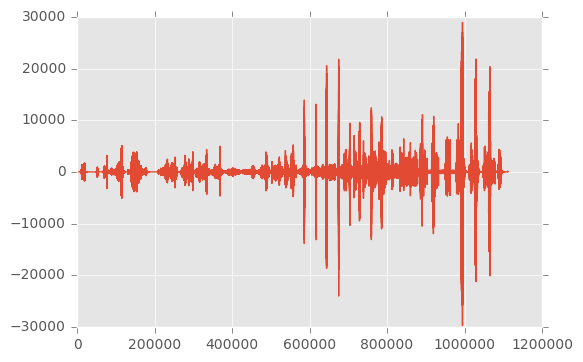

In [11]:
plt.plot(m_chunk.data[:, 0])

In [22]:
m_chunk.samples/30000

37

(<matplotlib.figure.Figure at 0x7fe9dca01450>,
 <matplotlib.axes._axes.Axes at 0x7fe9dc9da910>)

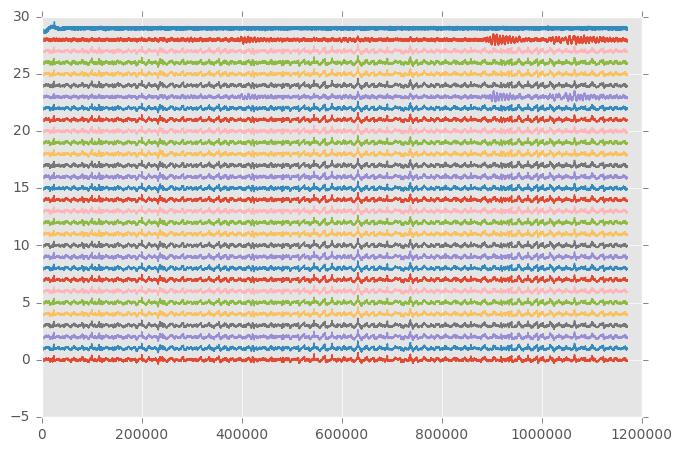

In [9]:
reload(st)
reload(et)
# bird = 'z030'
# sess = 'day-anesth_surface_2016-12-16_5'
# stim_sess = '001'

stim_name = 'bos01_tag'
fn = et.file_names(bird, sess)
exp_par = et.get_parameters(bird, sess)


stim_ev = get_evet(stim_name, bird, sess)
starts = stim_ev.get_start()
recs = stim_ev.get_rec()


i_bout = 18
neural_chans = np.array(exp_par['channel_config']['neural'] + [exp_par['channel_config']['mic']])
#neural_chans = np.array(exp_par['channel_config']['neural'])
bad_chans = np.array([0, 25, 31])
neural_chans = np.delete(neural_chans, bad_chans)
good_chans = [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, neural_chans[-1]]
#neural_chans = neural_chans[good_chans]

before = 30000
after = 30000
rec = recs[i_bout]
dset = kwdf.get_data_set(et.open_kwd(bird, sess), rec)
h5d = st.H5Data(dset, s_f, dtype=np.float)
start = starts[i_bout]

lfp_frame = st.Chunk(h5d, np.array(neural_chans), [start-before, start + m_chunk.samples + after])
lfp_frame.apply_filter(sp.apply_butter_bandpass, lfp_filter_pars)

lfp_frame.plot()

# update neural channels
#exp_par['channel_config']['neural_good']=neural_chans
#et.update_parameters(exp_par, bird, sess)

2017-03-28 15:18:07,179 bci.core.expstruct INFO     probe file: /mnt/cube/earneodo/bci_zf/probes/lhs2005b2_0.prb
2017-03-28 15:18:07,340 root         INFO     Collecting 75 frames...
2017-03-28 15:18:07,341 root         INFO     Frame 0 ...
2017-03-28 15:18:27,178 root         INFO     Frame 10 ...
2017-03-28 15:18:46,044 root         INFO     Frame 20 ...
2017-03-28 15:19:07,201 root         INFO     Frame 30 ...
2017-03-28 15:19:27,911 root         INFO     Frame 40 ...
2017-03-28 15:19:50,019 root         INFO     Frame 50 ...
2017-03-28 15:20:07,063 root         INFO     Frame 60 ...
2017-03-28 15:20:22,787 root         INFO     Frame 70 ...


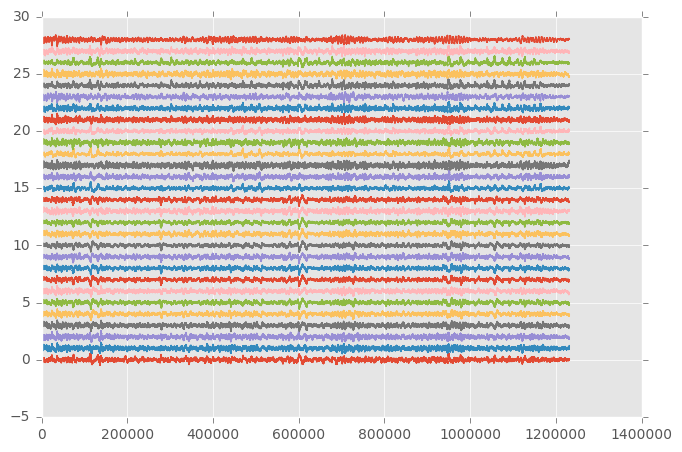

In [11]:
# bird = 'z030'
# sess = 'day-anesth_surface_2016-12-16_5'

# stim_name = 'bos_tag'
fn = et.file_names(bird, sess)
exp_par = et.get_parameters(bird, sess)
chan_map = load_site_chan_map(bird, sess)

try:
    neural_chans = exp_par['channel_config']['neural_good']
    selected_neural_chans = neural_chans[:-1]
except:
    pass

#elec_pos = chan_positions(selected_neural_chans, chan_map)/1200.

lfp_spectro_pars={'n_window': 256*1,
                  'n_overlap': 256*1-8,
                 'sigma': 30*15*4,
                 'f_cut': 1000,
                 'db_cut': 0.}

viz_set = {'stim_sess': '001', 
          'filter_pars': lfp_filter_pars, 
          'before_samp': 60000,
          'after_samp': 60000,
          'channels': neural_chans,
          'stim_chunk': None}

all_frames, all_starts, all_recs, stm_chunk = gather_all_frames(bird, sess, viz_set, stim_name=stim_name)
viz_set['stim_chunk'] = stm_chunk
st.list_apply_filter(all_frames, sp.apply_butter_bandpass, lfp_filter_pars)
st.list_apply_filter(all_frames, st.car, np.arange(neural_chans.size-1))

all_avg = st.sum_frames(all_frames)
st.plot_array(all_avg)
fig_name='fig_avg_traces_{0}_{1}.pdf'.format(sess, stim_name)
plt.savefig(os.path.join(fn['folders']['ss'], fig_name))

# chan = 2
# spec_chan = sp.Spectrogram(all_avg[:,chan], s_f, **lfp_spectro_pars)
# ax=spec_chan.plot(before_ms=2000, log_f=True, cmap='gnuplot2')
# chan = 2
# spec_chan = sp.Spectrogram(all_avg[:,chan], s_f, **lfp_spectro_pars)
# ax=spec_chan.plot(before_ms=2000, log_f=True, cmap='gnuplot2')

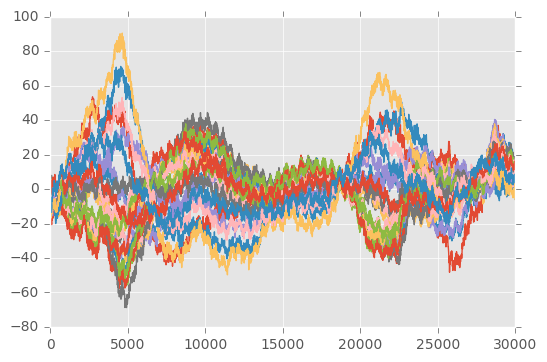

In [13]:
plt.plot(all_avg[110000:140000, :23]);

In [14]:
elec_pos = chan_positions(selected_neural_chans, chan_map)/1200.


NameError: name 'selected_neural_chans' is not defined

In [14]:
from pykCSD import pykCSD as cs
def plot_csd_point(in_data, sel_chans, ch_map, csd_pars={'gdX': 0.025, 'gdY': 0.025}):
    aux_elec_pos = chan_positions(sel_chans, ch_map)/100.
    aux_data = np.reshape(in_data, [-1, 1])
    print(elec_pos.shape)
    print(aux_data.shape)
    k_aux = cs.KCSD(aux_elec_pos, aux_data, csd_pars)
    k_aux.estimate_pots()
    k_aux.estimate_csd()

    k_aux.plot_all() 

def csd_all_points(in_data, in_elec_pos, csd_pars={'gdX': 0.025, 'gdY': 0.025}, step=1):
    # in_data is [n_samples, n_chans]
    n_samp, n_ch = in_data.shape
    csd_stack = []
    for i in np.arange(n_samp, step=step):
        if i % 100 == 0:
            logger.info("Sample {0}/{1} ...".format(i, n_samp))
        k_i = cs.KCSD(in_elec_pos, np.reshape(in_data[i, :], [-1, 1]), csd_pars)
        k_i.estimate_pots()
        k_i.estimate_csd()
        csd_stack.append(k_i.pass_estimation()[0][:,:,0])
    logger.info('Done with all csd samples')
    return np.stack(csd_stack, axis=2)


#plot_csd_point(all_avg[60500,:], selected_neural_chans, chan_map)
many_csd = csd_all_points(all_avg[60000:62500,:], elec_pos, step=100)



2017-01-20 19:05:37,633 root         INFO     Sample 0/2500 ...
2017-01-20 19:05:38,001 root         INFO     Sample 100/2500 ...
2017-01-20 19:05:38,321 root         INFO     Sample 200/2500 ...
2017-01-20 19:05:38,624 root         INFO     Sample 300/2500 ...
2017-01-20 19:05:38,935 root         INFO     Sample 400/2500 ...
2017-01-20 19:05:39,239 root         INFO     Sample 500/2500 ...
2017-01-20 19:05:39,555 root         INFO     Sample 600/2500 ...
2017-01-20 19:05:39,885 root         INFO     Sample 700/2500 ...
2017-01-20 19:05:40,190 root         INFO     Sample 800/2500 ...
2017-01-20 19:05:40,494 root         INFO     Sample 900/2500 ...
2017-01-20 19:05:40,799 root         INFO     Sample 1000/2500 ...
2017-01-20 19:05:41,102 root         INFO     Sample 1100/2500 ...
2017-01-20 19:05:41,406 root         INFO     Sample 1200/2500 ...
2017-01-20 19:05:41,710 root         INFO     Sample 1300/2500 ...
2017-01-20 19:05:42,021 root         INFO     Sample 1400/2500 ...
2017-01

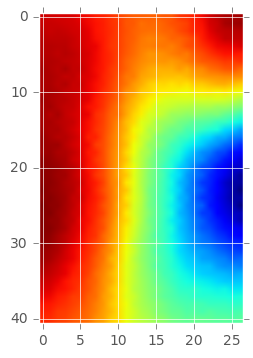

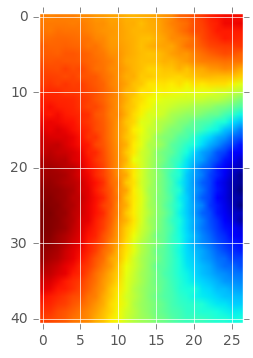

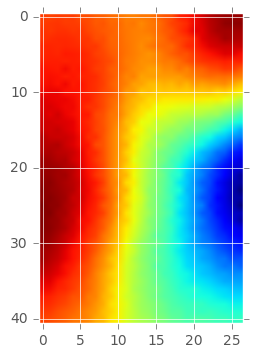

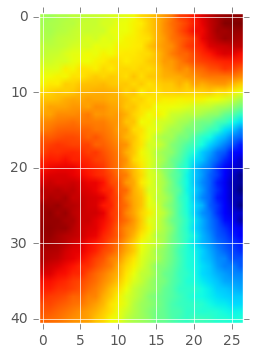

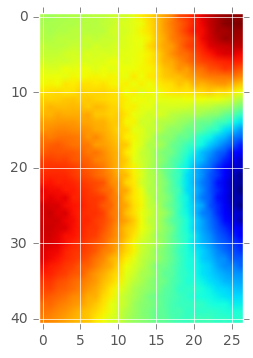

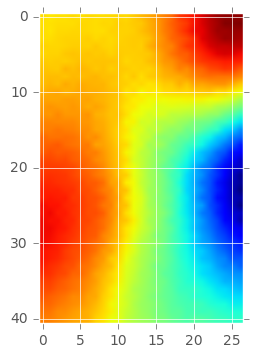

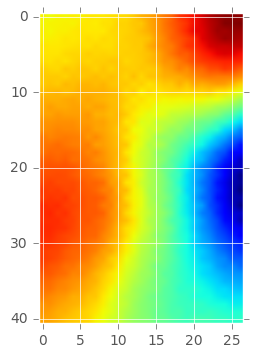

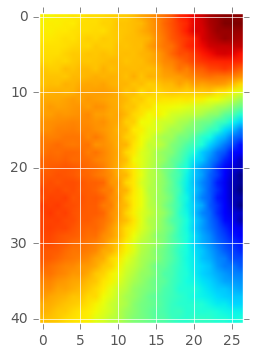

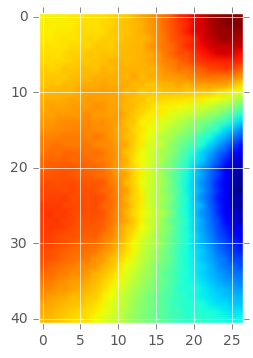

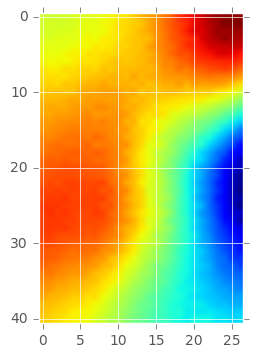

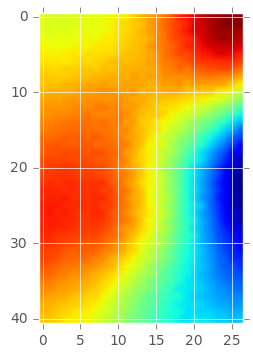

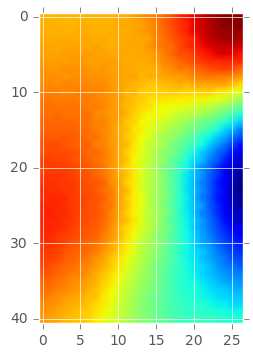

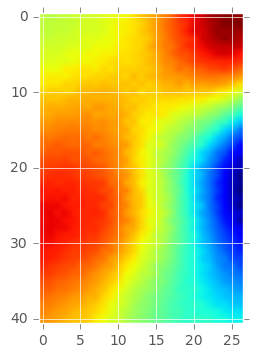

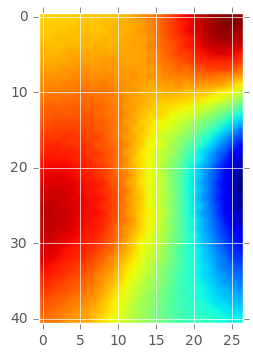

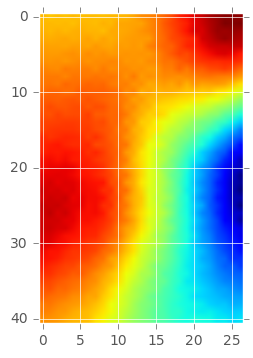

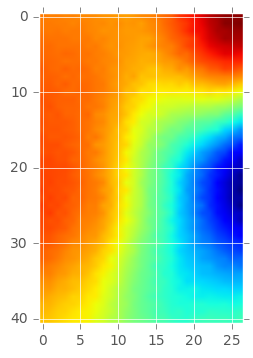

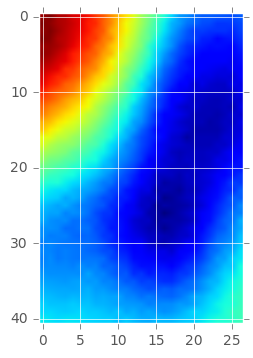

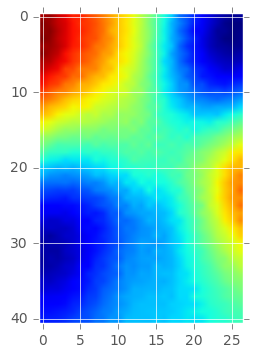

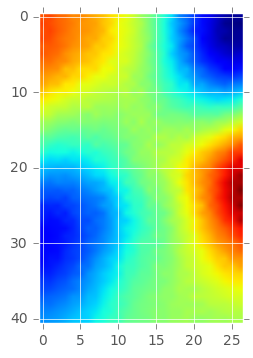

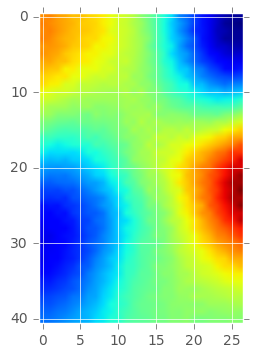

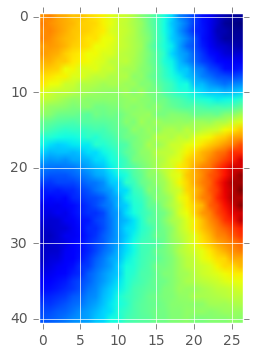

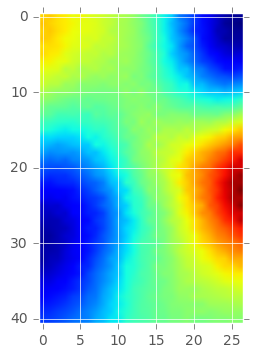

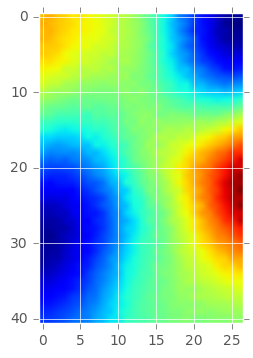

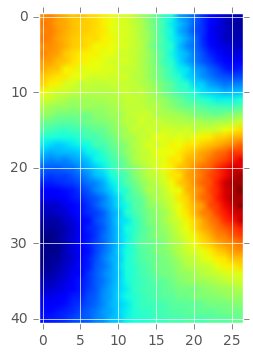

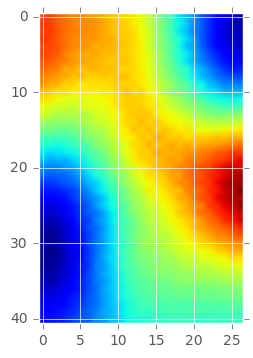

In [117]:
for i in range(25):
    plt.figure()
    plt.imshow(many_csd[: , :, i])

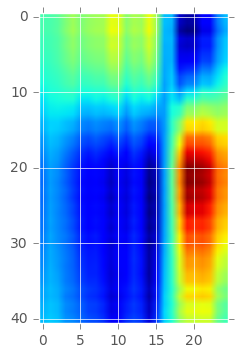

In [136]:
plt.imshow(many_csd[:, 20, :])

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

In [35]:
new_csd = np.append(many_csd, np.zeros([41, 1, 25]), axis=1)

In [73]:
def mark_stim(csd_data, stim_vec, step=1):
    [n_x, n_y, n_steps] = csd_data.shape
    min_c = np.min(csd_data)
    max_c = np.max(csd_data)
    new_csd = np.append(csd_data, np.zeros([n_x, 1, n_steps]), axis=1)
    new_csd[:, -1, np.where(stim_vec)] = max_c
    new_csd[:, -1, np.where(~stim_vec)] = max_c

def make_stim_vec(vis_set, step):
    bef_samp = vis_set['before_samp']
    aft_samp = vis_set['after_samp']
    total_size = bef_samp + aft_samp + vis_set['stim_chunk'].samples
    stim_vec = np.zeros(np.int(np.floor(total_size/step)), dtype=np.bool)
    stim_vec[np.int(bef_samp/step):-np.int(aft_samp/step)] = True
    return stim_vec

st_vec = (make_stim_vec(viz_set, 100))
new_csd = mark_stim(many_csd, st_vec, step = 100)

IndexError: index 600 is out of bounds for axis 2 with size 25

IndexError: index 600 is out of bounds for axis 2 with size 25

In [70]:
csd_all_points

<function __main__.csd_all_points>

In [79]:
viz_set

{'after_samp': 60000,
 'before_samp': 60000,
 'channels': array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 29, 30,
        32]),
 'csd': {'steps': 100},
 'filter_pars': {'hi_cut': 1250,
  'hp_a': array([ 1.        , -3.99945271,  5.99835827, -3.99835842,  0.99945286]),
  'hp_b': array([ 0.99972639, -3.99890557,  5.99835835, -3.99890557,  0.99972639]),
  'lo_cut': 1,
  'lp_a': array([ 1.        , -3.31680791,  4.17424555, -2.35740278,  0.50337536]),
  'lp_b': array([ 0.00021314,  0.00085255,  0.00127883,  0.00085255,  0.00021314])},
 'stim_chunk': <streamtools.streams.Chunk instance at 0x7f0ae460a440>,
 'stim_sess': '001'}

In [78]:
viz_set['csd']={'steps':100}

-28509.0
26515.0


(<matplotlib.lines.Line2D at 0x7f0a09ab0c50>,)

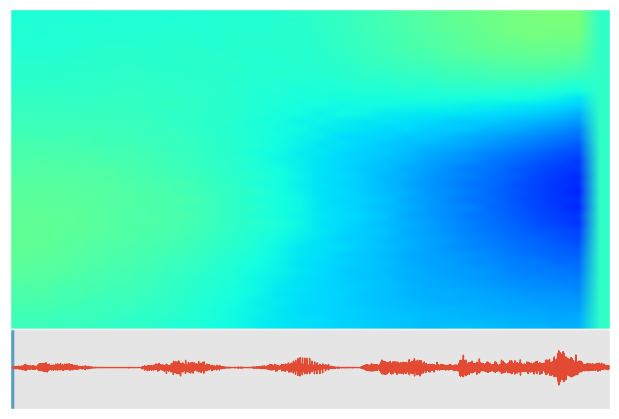

In [210]:
import matplotlib.patches as patches

class CsdViewer():
    def __init__(self, csd_data, vis_pars):
        self.csd = csd_data
        self.stim_chk = vis_pars['stim_chunk']
        self.stim_data = None
        self.v_p = vis_pars
        self.step_samples = vis_pars['csd']['steps']        
        self.step = 0
        self.hws = 7500 #half_window_size
        self.fig_width = 1
        self.fig = None
        self.fig_ax = {}
        self.fig_plt = {}
        self.disp_chnk = None
        self.stim_patch = None
    
    
    def init_fig(self):
        self.fig = plt.figure()
        self.fig_ax['csd'] = self.fig.add_axes([0,.2,self.fig_width,0.8])
        self.fig_ax['stim'] = self.fig.add_axes([0,0,self.fig_width,0.2])
        for ax in self.fig_ax.itervalues():
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])

       

        self.init_stim()
        self.init_csd()
        self.update_csd()
        self.update_stim()
    
    
    def init_stim(self):
        self.stim_data = np.hstack([np.zeros(self.v_p['before_samp'] + self.hws), 
                        self.stim_chk.data[:, 0],
                        np.zeros(self.v_p['after_samp'] + self.hws)])
        self.stim_data = np.hstack([ 
                        self.stim_chk.data[:, 0],
                        np.zeros(self.v_p['after_samp'] + self.hws)])
        
         
        min_stim = np.min(self.stim_data)
        max_stim = np.max(self.stim_data)
        print min_stim
        print max_stim
        ax=self.fig_ax['stim']
        ax.set_xlim([np.min(self.stim_data), np.max(self.stim_data)])
        ax.set_xlim((0, 2*self.hws))
        ax.set_ylim((min_stim, max_stim))
        
#         self.stim_patch = patches.Rectangle((0, min_stim), self.step_samples, 
#                                        min_stim + max_stim, alpha=0.6)
        self.stim_patch = patches.Rectangle((0, min_stim), 
                                            self.step_samples, np.diff([min_stim, max_stim]), 
                                            alpha=.4)
        self.fig_plt['stim'],  = self.fig_ax['stim'].plot([],[])
        self.fig_plt['stim'].set_data([],[])
        self.fig_plt['stim_bar'] = self.fig_ax['stim'].add_patch(self.stim_patch)

        
    def init_csd(self):
        self.fig_plt['csd'] = self.fig_ax['csd'].imshow(new_csd[:,:,0], 
                                         aspect='auto', 
                                         animated=True, 
                                         vmin=np.min(self.csd[:,:,:]), 
                                         vmax=np.max(self.csd[:,:,:]))


    def update_stim(self):    
        ax = self.fig_ax['stim']
        start = self.step*self.step_samples
        self.disp_chnk = self.stim_data[start: start + 2*self.hws]
        self.fig_plt['stim'].set_data(np.arange(self.disp_chnk.size), self.disp_chnk)
        self.fig_plt['stim_bar'] = self.fig_ax['stim'].add_patch(self.stim_patch)

    def update_csd(self):
        ax = self.fig_ax['csd']
        im = self.fig_plt['csd']
        im.set_array(new_csd[:,:,self.step])
        return im,

    def update_fig(self, step):
        self.step = step
        self.update_stim()
        self.update_csd()
        return self.fig_plt['stim'],

    def animate(self):
        pass
        
    
cad_v = CsdViewer(new_csd, viz_set)
cad_v.init_fig()
cad_v.update_fig(5)

# anim = animation.FuncAnimation(cad_v.fig, cad_v.update_fig, np.arange(25), blit=True)
# HTML(anim.to_html5_video())

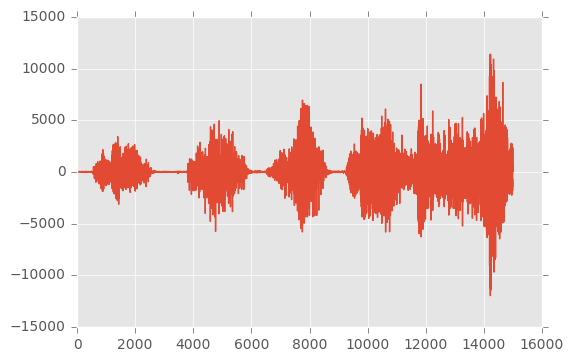

In [140]:
plt.plot(np.arange(cad_v.disp_chnk.size), cad_v.disp_chnk);

/usr/local/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


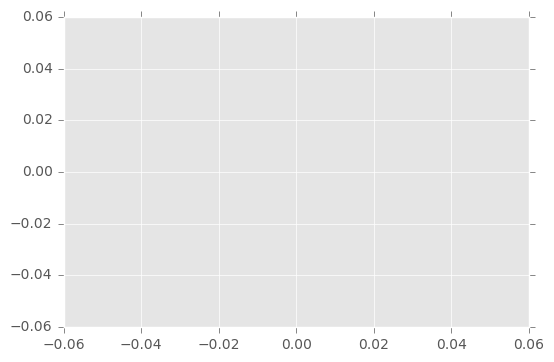

In [148]:
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
line.set_data(np.arange(cad_v.disp_chnk.size), cad_v.disp_chnk)
fig.show()

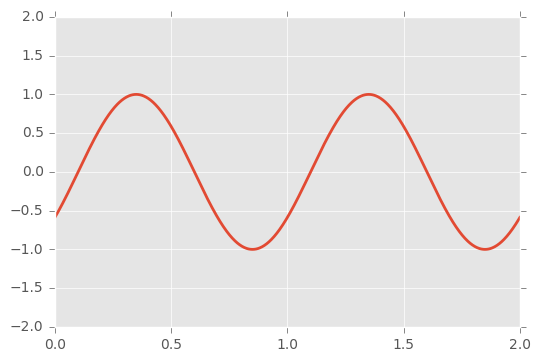

In [149]:
fig, ax = plt.subplots()

ax.set_xlim(( 0, 15000))
ax.set_ylim((-2, 2))
i=10
line, = ax.plot([], [], lw=2)
x = np.linspace(0, 2, 1000)
y = np.sin(2 * np.pi * (x - 0.01 * i))
line.set_data(x, y)

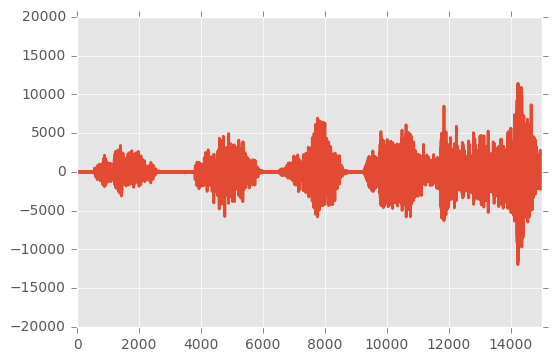

In [156]:
fig, ax = plt.subplots()

ax.set_xlim(( 0, 15000))
ax.set_ylim((-20000, 20000))
i=10
line, = ax.plot([], [], lw=2)
x = np.arange(cad_v.disp_chnk.size)
y = cad_v.disp_chnk
line.set_data(x, y)

In [175]:
im

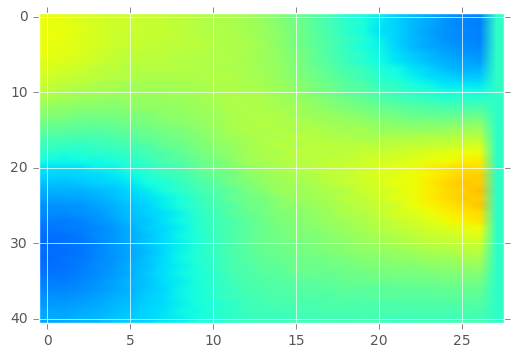

In [74]:
fig = plt.figure()

im = plt.imshow(new_csd[:,:,0], aspect='auto', animated=True, vmin=np.min(new_csd[:,:,:]), vmax=np.max(new_csd[:,:,:]))


def updatefig(t):
    im.set_array(new_csd[:,:,t])
    #plt.colorbar()
    return im,

ani = animation.FuncAnimation(fig, updatefig, np.arange(25), blit=True)
HTML(ani.to_html5_video())

In [102]:
np.hstack([ np.zeros(viz_set['before_samp'] + 100), viz_set['stim_chunk'].data[:,0]]).shape

(90051,)

In [97]:
viz_set['stim_chunk'].data[:,0].shape

(29951,)

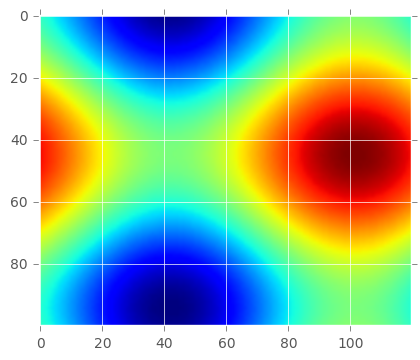

In [17]:
fig = plt.figure()


def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)

im = plt.imshow(f(x, y), animated=True)


def updatefig(*args):
    global x, y
    x += np.pi / 15.
    y += np.pi / 20.
    im.set_array(f(x, y))
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=50, blit=True)
HTML(ani.to_html5_video())

Initializing kCSD 2D


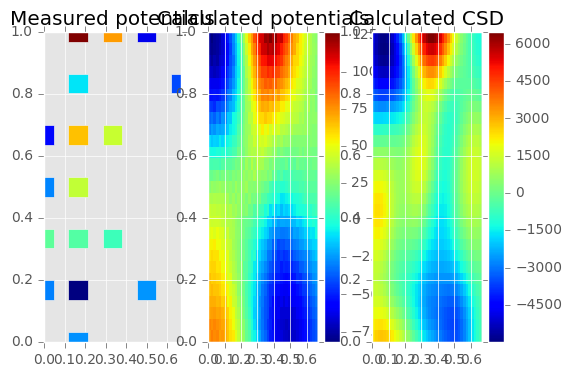

In [99]:
pots = np.reshape(all_avg[62000,:], [-1, 1])
k = cs.KCSD(elec_pos, pots, params)

k.estimate_pots()
k.estimate_csd()

k.plot_all()

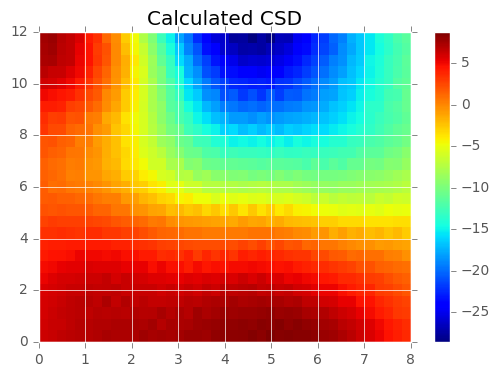

In [101]:
timeframe=0
extent = csd_estim[2]

fig = plt.figure()
ax13 = fig.add_subplot(1, 1, 1)
im2 = ax13.imshow(many_csd[:, :, timeframe].T, interpolation='none',
                extent=extent, aspect="auto", origin='lower')
plt.colorbar(im2)    
ax13.set_title('Calculated CSD')

plt.show()

In [45]:
pots = np.reshape(all_avg[61000,:], [-1, 1])
k = cs.KCSD(elec_pos, pots, params)

k.estimate_pots()
k.estimate_csd()

k.plot_all()

(17, 1)

Initializing kCSD 2D


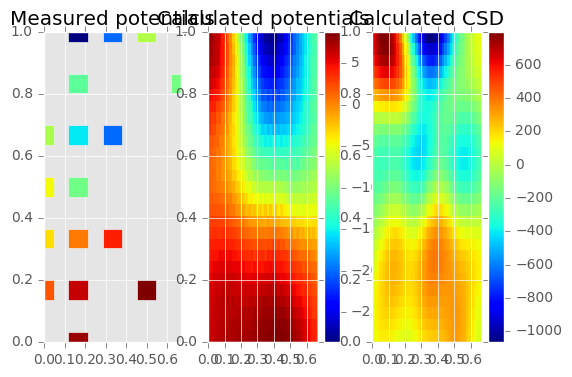

In [94]:
pots = np.reshape(all_avg[60000,:], [-1, 1])
k = cs.KCSD(elec_pos, pots, params)

k.estimate_pots()
k.estimate_csd()

k.plot_all()

Initializing kCSD 2D


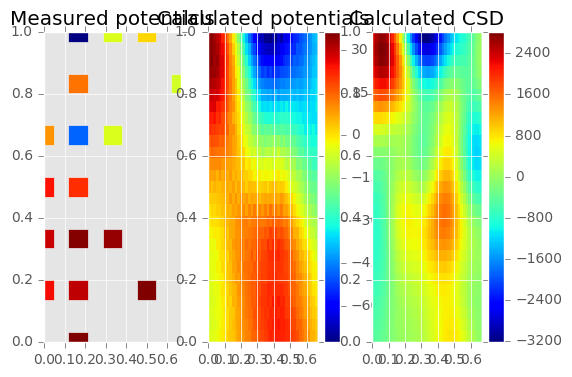

In [96]:
csd_pars = {'gdX': 0.025, 'gdY': 0.025}

pots = np.reshape(all_avg[61000,:], [-1, 1])
k = cs.KCSD(elec_pos, pots, csd_pars)

k.estimate_pots()
k.estimate_csd()

k.plot_all()

In [73]:
csd_estim[0][:,:,0]

array([[ 6.64425569,  6.63447069,  6.679351  , ...,  2.88379268,
         2.94737771,  3.0572016 ],
       [ 6.74264916,  6.65709188,  6.72478141, ...,  2.9037578 ,
         2.88470844,  2.97589392],
       [ 6.69744118,  6.73330265,  6.74725941, ...,  2.92327134,
         3.00533073,  3.06382134],
       ..., 
       [ 6.26969593,  6.25916658,  6.28612522, ..., -5.8478683 ,
        -5.91834566, -5.77641303],
       [ 6.20201822,  6.14181815,  6.164197  , ..., -5.78591251,
        -5.813108  , -5.75470473],
       [ 6.1509302 ,  6.10920116,  6.08647876, ..., -5.79649748,
        -5.80599372, -5.67038533]])

In [59]:
csd_estim[1].shape

(481, 321, 1)

In [64]:
len(csd_estim)

3

In [63]:
csd_estim[2]

[0.0, 8.0, 0.0, 12.0]

2017-01-11 08:53:55,094 root         INFO     Collecting 75 frames...
2017-01-11 08:53:55,096 root         INFO     Frame 0 ...
2017-01-11 08:53:55,393 root         INFO     Frame 10 ...
2017-01-11 08:53:55,624 root         INFO     Frame 20 ...
2017-01-11 08:53:55,847 root         INFO     Frame 30 ...
2017-01-11 08:53:56,069 root         INFO     Frame 40 ...
2017-01-11 08:53:56,281 root         INFO     Frame 50 ...
2017-01-11 08:53:56,472 root         INFO     Frame 60 ...
2017-01-11 08:53:56,663 root         INFO     Frame 70 ...


4993.86666667
fcut_plot 6.90775527898
4993.86666667
fcut_plot 6.90775527898


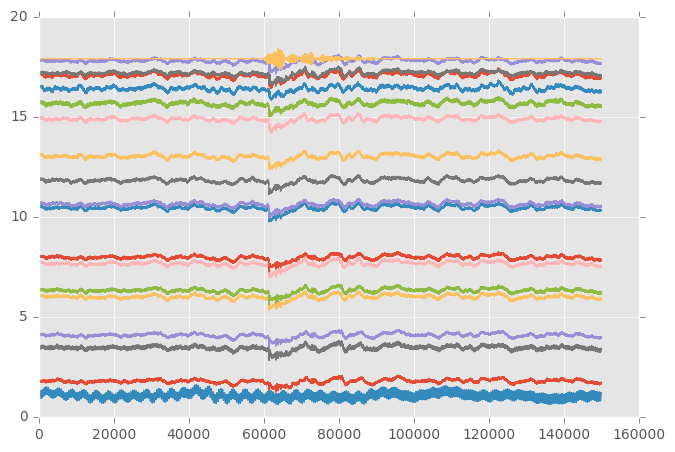

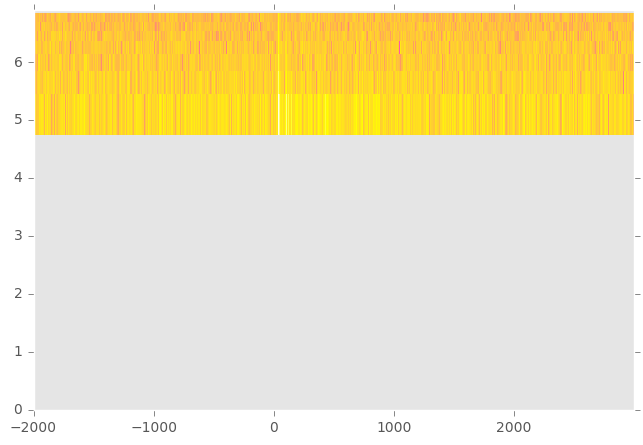

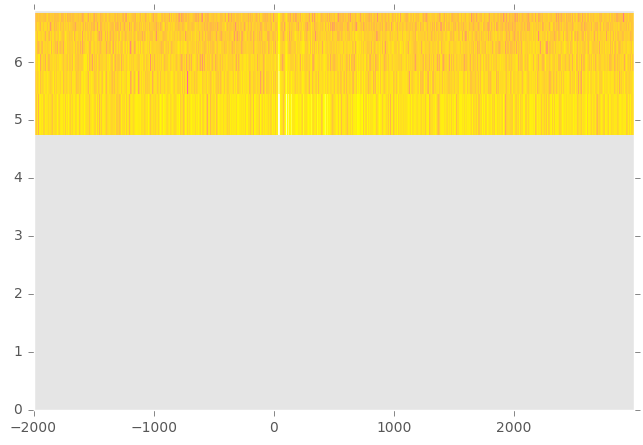

In [7]:
sess = 'day-anesth_surface_2016-12-16_3'
stim_name = 'bos_rev_tag'
lfp_spectro_pars={'n_window': 256*1,
                  'n_overlap': 256*1-8,
                 'sigma': 30*15*4,
                 'f_cut': 1000,
                 'db_cut': 0.}

viz_set = {'stim_sess': '001', 
          'filter_pars': filter_pars, 
          'before_samp': 60000,
          'after_samp': 60000,
          'channels': neural_chans}

fn = et.file_names(bird, sess)

all_frames, all_starts, all_recs, stm_chunk = gather_all_frames(bird, sess, viz_set, stim_name=stim_name)

all_avg = st.sum_frames(all_frames)
st.plot_array(all_avg)
fig_name='fig_avg_traces_{0}_{1}.pdf'.format(sess, stim_name)
plt.savefig(os.path.join(fn['folders']['ss'], fig_name))

chan = 8
spec_chan = sp.Spectrogram(all_avg[:,chan], s_f, **lfp_spectro_pars)
ax=spec_chan.plot(before_ms=2000, log_f=True, cmap='gnuplot2')
chan = 2
spec_chan = sp.Spectrogram(all_avg[:,chan], s_f, **lfp_spectro_pars)
ax=spec_chan.plot(before_ms=2000, log_f=True, cmap='gnuplot2')

In [14]:
all_frames[0].data[:, 1]

array([  87.,   93.,  130., ...,  106.,  105.,  133.])

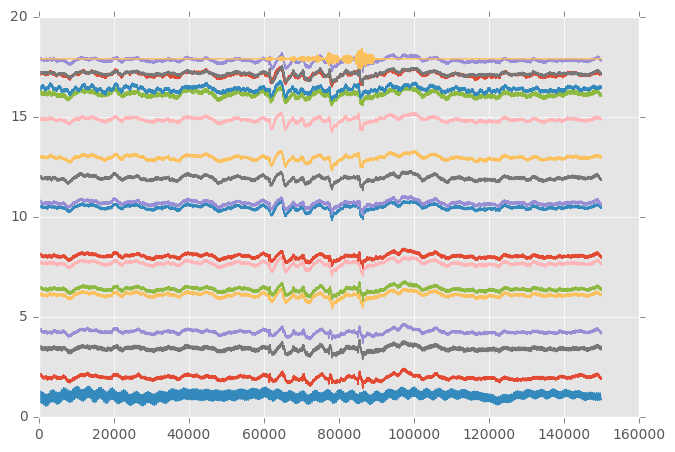

In [48]:
stim_name = 'bos_tag'
st.plot_array(all_avg)
fig_name='fig_avg_traces_{0}_{1}.pdf'.format(sess, stim_name)
plt.savefig(os.path.join(fn['folders']['ss'], fig_name))

2017-01-10 13:49:29,912 root         INFO     Collecting 75 frames...
2017-01-10 13:49:29,913 root         INFO     Frame 0 ...
2017-01-10 13:49:31,789 root         INFO     Frame 10 ...
2017-01-10 13:49:33,070 root         INFO     Frame 20 ...
2017-01-10 13:49:34,357 root         INFO     Frame 30 ...
2017-01-10 13:49:35,859 root         INFO     Frame 40 ...
2017-01-10 13:49:37,221 root         INFO     Frame 50 ...
2017-01-10 13:49:38,511 root         INFO     Frame 60 ...
2017-01-10 13:49:39,690 root         INFO     Frame 70 ...


4993.86666667
fcut_plot 6.90775527898


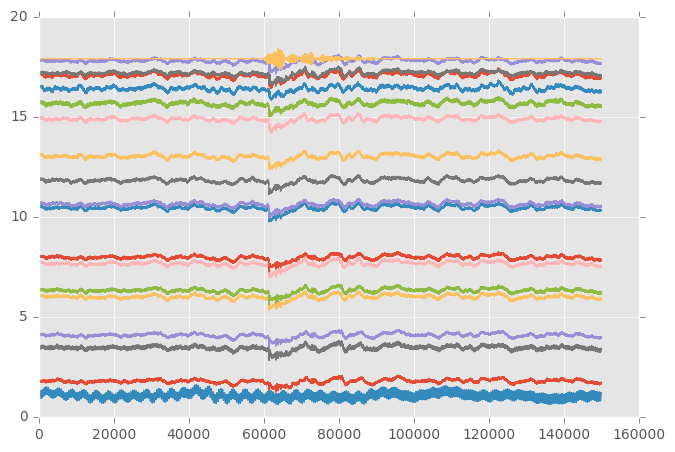

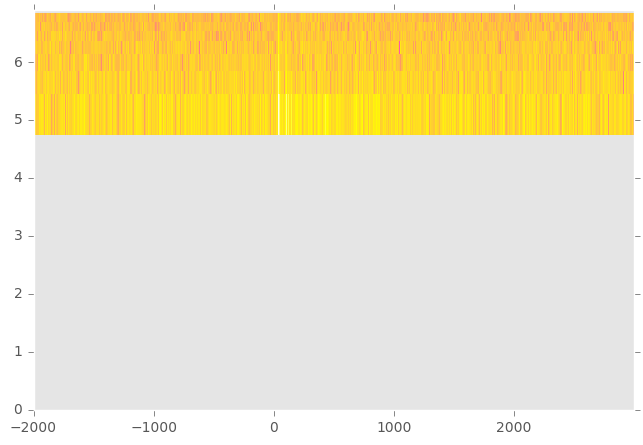

In [42]:
all_frames, all_starts, all_recs, stm_chunk = gather_all_frames(bird, sess, viz_set, stim_name='bos_rev_tag')

all_avg = st.sum_frames(all_frames)
st.plot_array(all_avg)
chan = 8
spec_chan = sp.Spectrogram(all_avg[:,chan], s_f, **lfp_spectro_pars)
ax=spec_chan.plot(before_ms=2000, log_f=True, cmap='gnuplot2')

2017-01-10 13:46:39,464 root         INFO     Collecting 70 frames...
2017-01-10 13:46:39,466 root         INFO     Frame 0 ...
2017-01-10 13:46:40,974 root         INFO     Frame 10 ...
2017-01-10 13:46:42,287 root         INFO     Frame 20 ...
2017-01-10 13:46:43,514 root         INFO     Frame 30 ...
2017-01-10 13:46:45,058 root         INFO     Frame 40 ...
2017-01-10 13:46:46,479 root         INFO     Frame 50 ...
2017-01-10 13:46:47,457 root         INFO     Frame 60 ...


(<matplotlib.figure.Figure at 0x7fd9db7dc650>,
 <matplotlib.axes._axes.Axes at 0x7fd9db30fd90>)

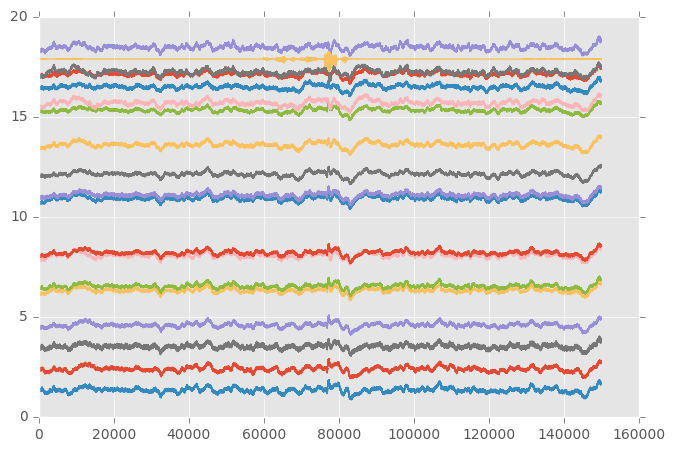

In [37]:
all_frames, all_starts, all_recs, stm_chunk = gather_all_frames(bird, sess, viz_set, stim_name='con_syn_tag')

all_avg = st.sum_frames(all_frames)
st.plot_array(all_avg)

2017-01-10 10:52:27,640 root         INFO     Collecting 70 frames...
2017-01-10 10:52:27,642 root         INFO     Frame 0 ...
2017-01-10 10:52:27,976 root         INFO     Frame 10 ...
2017-01-10 10:52:28,146 root         INFO     Frame 20 ...
2017-01-10 10:52:28,316 root         INFO     Frame 30 ...
2017-01-10 10:52:28,536 root         INFO     Frame 40 ...
2017-01-10 10:52:28,728 root         INFO     Frame 50 ...
2017-01-10 10:52:28,913 root         INFO     Frame 60 ...


(<matplotlib.figure.Figure at 0x7fd9dbc58b10>,
 <matplotlib.axes._axes.Axes at 0x7fd9d1d3ab90>)

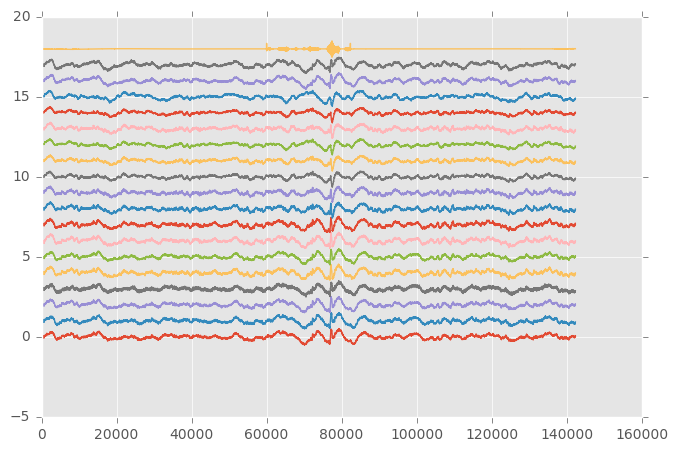

In [10]:
logger.setLevel(logging.INFO)
before = 60000
after = 60000

all_frames, all_starts, all_recs = collect_frames(starts-before, before+after+m_chunk.samples, 
                            s_f, 
                            kwd_file, recs, neural_chans)

nothing = st.list_apply_filter(all_frames, sp.apply_butter_bandpass, filter_pars)

# average across all frames
reload(st)
all_avg = st.sum_frames(all_frames)
st.plot_array(all_avg)

4198.13333333
fcut_plot 5.70378247466


/mnt/cube/earneodo/repos/swissknife/streamtools/spectral.py:78: RuntimeWarning: divide by zero encountered in log
  f_plot = np.log(f) if log_f else f


NameError: name 'first_avg' is not defined

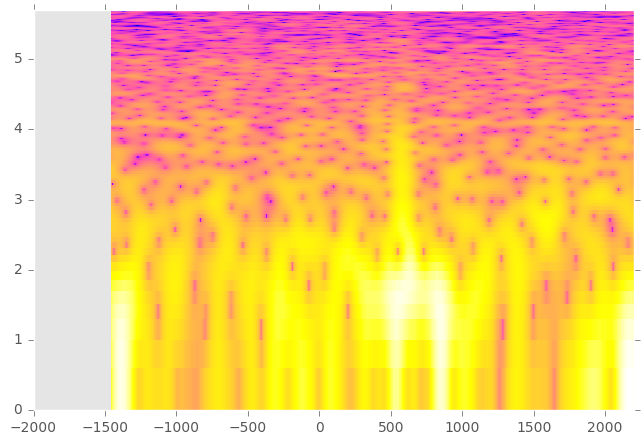

In [11]:
lfp_spectro_pars={'n_window': 4096*8,
                  'n_overlap': 4096*8-8,
                 'sigma': 30*15*4,
                 'f_cut': 300,
                 'db_cut': 0.}

chan = 8
spec_chan = sp.Spectrogram(all_avg[:,chan], s_f, **lfp_spectro_pars)
ax=spec_chan.plot(before_ms=2000, log_f=True, cmap='gnuplot2')


3452.0
fcut_plot 5.70378247466


(<matplotlib.figure.Figure at 0x7fa479e066d0>,
 <matplotlib.axes._axes.Axes at 0x7fa48bc79850>)

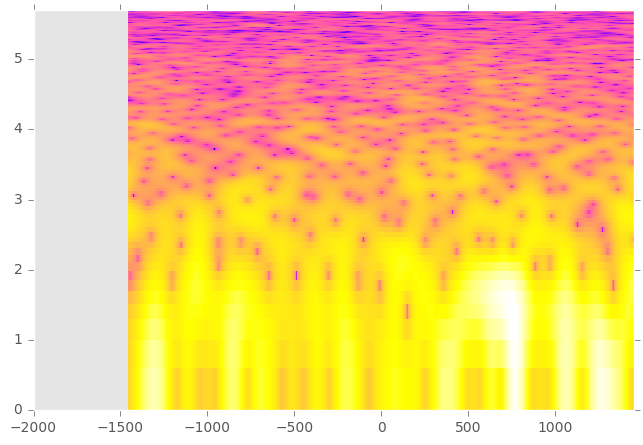

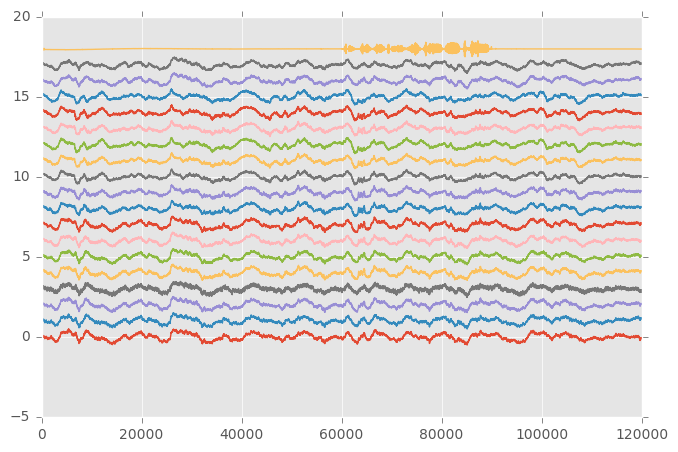

In [99]:
lfp_spectro_pars={'n_window': 4096*8,
                  'n_overlap': 4096*8-8,
                 'sigma': 30*15*4,
                 'f_cut': 300,
                 'db_cut': 0.}

chan = 8
spec_chan = sp.Spectrogram(all_avg[:,chan], s_f, **lfp_spectro_pars)
ax=spec_chan.plot(before_ms=2000, log_f=True, cmap='gnuplot2')
first_avg.plot()

In [31]:
f_cut = 70
n_window = 2048*8
n_overlap = n_window-8

response_spectrogram = spectrogram(first_avg.data[:, 8], s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma*30), 
                                  scaling='spectrum')

plt.pcolormesh(response_spectrogram[1]*s_f, 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(response_spectrogram[2][response_spectrogram[0] < f_cut, :]))

NameError: name 'sigma' is not defined

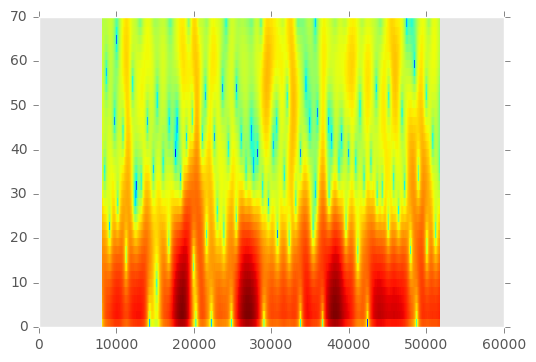

In [14]:
response_spectrogram = spectrogram(lfp_frame.data[:, 6], s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma*15), 
                                  scaling='spectrum')

plt.pcolormesh(response_spectrogram[1]*s_f, 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(response_spectrogram[2][response_spectrogram[0] < f_cut, :]))

In [26]:
# quick confirm of the avg lfp
n_trials = starts.size - 1
n_samples = m_chunk.samples + after + before
n_chans = neural_chans.size

spectr_shape = response_spectrogram[2].shape
n_x = spectr_shape[0]
n_y = spectr_shape[1]

spectr = np.empty([n_trials, n_x, n_y])
lfp = np.empty([n_samples, n_trials, n_chans], dtype=np.float)


spectr_stack = []

for ch in range(n_chans):
    print ch
    for i_trial in range(n_trials):
        start = starts[i_trial]
        one_frame = st.Chunk(h5d, np.array(neural_chans), [start-before, start + m_chunk.samples + after])
        lfp[:, i_trial, :] = one_frame.data
        this_spectrogram = spectrogram(one_frame.data[:, ch], s_f, 
                                      nperseg = n_window, 
                                      noverlap= n_overlap, 
                                      window = sg.gaussian(n_window, sigma*50), 
                                      scaling='density')
        spectr[i_trial, :, :] = (this_spectrogram[2])
    
    spectr_stack.append(spectr)
    
#all_spectra = np.stack(spectr_stack, axis=0)

0
1
2
3
4
5
6
7


MemoryError: 

In [66]:
all_spectra = np.stack(spectr_stack, axis=0)

MemoryError: 

In [52]:
spectr_stack[0].shape

(74, 8193, 3890)

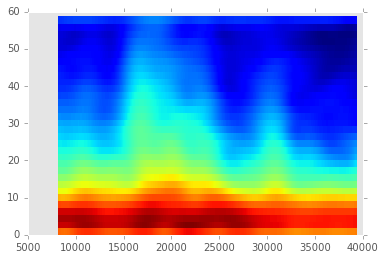

In [28]:
f_cut = 60
ch = 2
mean_spectr = np.mean(spectr_stack[ch], axis=0)
plt.pcolormesh(response_spectrogram[1]*s_f, 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(mean_spectr[:,:][response_spectrogram[0] < f_cut, :]))

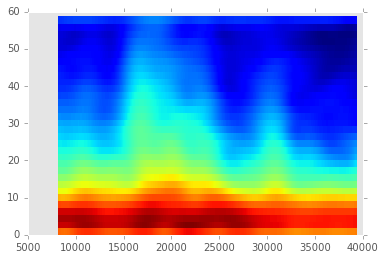

In [34]:
f_cut = 60
ch = 4
mean_spectr = np.mean(spectr_stack[ch], axis=0)
plt.pcolormesh(response_spectrogram[1]*s_f, 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(mean_spectr[:,:][response_spectrogram[0] < f_cut, :]))

In [17]:
plt.figure(1)
plt.subplot(311)
plt.plot(np.mean(lfp[:, :, 1], axis=1))
plt.subplot(312)
plt.pcolormesh(response_spectrogram[1], 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(mean_spectrogram[2][response_spectrogram[0] < f_cut, :]))
plt.subplot(313)
plt.plot(lfp[:,4,0])
plt.show()
fig_name = os.path.join(fn['folders']['ss'], 'spectrum_avg_{}.png'.format(m_name))
plt.savefig(fig_name, format='png')

(49, 2049, 3680)

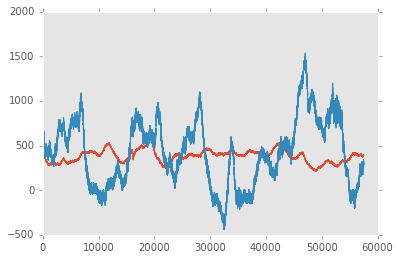

In [82]:
plt.plot(np.mean(lfp[:, :, 1], axis=1))
plt.plot(lfp[:,4,1])

f_cut = 150
n_window = 2048
n_overlap = n_window - 1
response_spectrogram = spectrogram(np.mean(lfp[:, :, 1], axis=1), s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma), 
                                  scaling='spectrum')

plt.pcolormesh(response_spectrogram[1], 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(response_spectrogram[2][response_spectrogram[0] < f_cut, :]))

song_file_path = et.file_path(fn, 'ss', 'sng')
fig_name = os.path.join(fn['folders']['ss'], 'trial_vs_avg_{}.png'.format(m_name))
plt.savefig(fig_name, format='png')

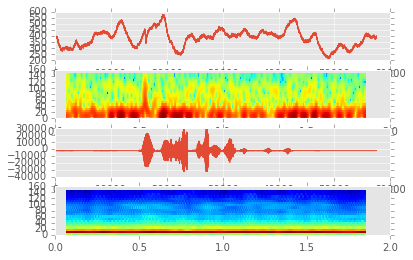

In [83]:
f_cut = 150
n_window = 4096
n_overlap = n_window-8
response_spectrogram = spectrogram(np.mean(lfp[:, :, 1], axis=1), s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma*10), 
                                  scaling='spectrum')
plt.figure(3)
plt.subplot(411)
plt.plot(np.mean(lfp[:, :, 1], axis=1))
plt.subplot(412)
plt.pcolormesh(response_spectrogram[1], 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(response_spectrogram[2][response_spectrogram[0] < f_cut, :]))
plt.subplot(413)
plt.plot(lfp[:,4,0])
plt.subplot(414)
plt.pcolormesh(response_spectrogram[1], 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(mean_spectr[:,:][response_spectrogram[0] < f_cut, :]))
fig_name = os.path.join(fn['folders']['ss'], 'spectrum_avg_{}.png'.format(m_name))
plt.savefig(fig_name, format='png')
plt.show()


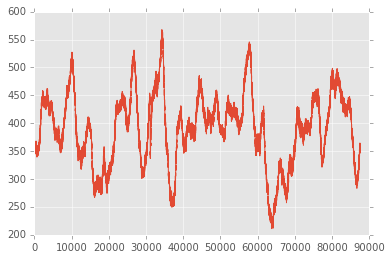

In [96]:
plt.plot(np.mean(lfp[:, :, 1], axis=1))

In [24]:
n_starts = m_starts.size
n_chans = neural_chans.size
n_samples = before + after + m_chunk.samples

sup_lfp = np.empty([n_chans, n_starts, n_samples], dtype=np.float)

for rec in np.unique(recs):
    dset = h5.get_data_set(kwd_file, rec)
    h5d = H5Data(dset, s_f, dtype=np.float)
    this_rec = np.where(recs==rec)[0]
    print this_rec
    for i_trial, start in zip(this_rec, starts[this_rec][:-1]):
        print i_trial
        sup_lfp[:, i_trial, :] = h5d.get_chunk(start-before, start + m_chunk.samples + after, neural_chans).T


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


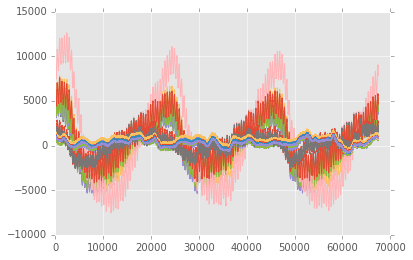

In [10]:
plt.plot(sup_lfp[:,7,:].T)

In [37]:
np.unique(recs)

array([0])

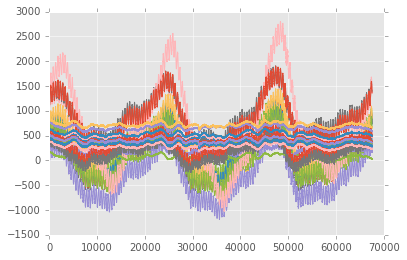

In [11]:
trial_mean = np.mean(sup_lfp, axis=1)
trial_mean.shape
plt.plot(trial_mean.T)

In [15]:
trial_mean = np.mean(sup_lfp, axis=1)
trial_mean.shape

(31, 67535)

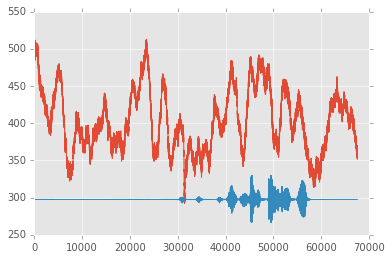

In [38]:
plt.plot(trial_mean[30,:])
plt.plot(lfp_frame.data[:,31]/1000. + 300)

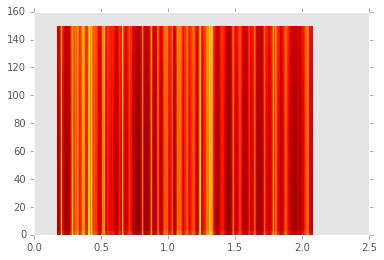

In [46]:
f_cut = 150
n_window = 1024*10
n_overlap = n_window - 1
response_spectrogram = spectrogram(trial_mean[30,:], s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma), 
                                  scaling='spectrum')

plt.pcolormesh(response_spectrogram[1], 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(response_spectrogram[2][response_spectrogram[0] < f_cut, :]))

In [ ]:
scipy.io.wavfile.write(filename, rate, data)

In [49]:
wavfile.write('one_channel.wav', 30000, trial_mean[30,:].astype(np.int16))


In [48]:
pwd

u'/mnt/cube/earneodo/repos/ephysflow'